# 30 epochs with early stopping: 

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.callbacks import EarlyStopping

# Import the specific helper functions for training and testing
from helperFunctions_train import createDataSet_train
from helperFunctions_test import createDataSet_test

# Load the datasets
train_file = "../../data/Ohio2020_processed/train/540-ws-training_processed.csv"
test_file = "../../data/Ohio2020_processed/test/540-ws-testing_processed.csv"

# Create training and testing datasets using the separate functions
train_data = createDataSet_train(train_file)
test_data = createDataSet_test(test_file)

# Verify the number of data points
print(f"Number of training data points (initial): {sum(len(df) for df in train_data)}")
print(f"Number of test data points (initial): {sum(len(df) for df in test_data)}")


Number of training data points (initial): 1166
Number of test data points (initial): 345


In [6]:

# Data Preparation
def prepare_data(data, time_steps=3):
    X, y = [], []
    for i in range(len(data) - time_steps):
        X.append(data.iloc[i:(i + time_steps)].drop("cbg", axis=1).values)
        y.append(data.iloc[i + time_steps]["cbg"])
    return np.array(X), np.array(y)

# Combine all sub-dataframes from createDataSet output
train_data_combined = pd.concat(train_data, axis=0).reset_index(drop=True)
test_data_combined = pd.concat(test_data, axis=0).reset_index(drop=True)

print(f"Number of training data points (combined): {len(train_data_combined)}")
print(f"Number of test data points (combined): {len(test_data_combined)}")

# Normalize the data using MinMaxScaler
scaler = MinMaxScaler()
train_data_combined_scaled = pd.DataFrame(scaler.fit_transform(train_data_combined), columns=train_data_combined.columns)
test_data_combined_scaled = pd.DataFrame(scaler.transform(test_data_combined), columns=test_data_combined.columns)

print(f"Number of training data points (after scaling): {len(train_data_combined_scaled)}")
print(f"Number of test data points (after scaling): {len(test_data_combined_scaled)}")


Number of training data points (combined): 1104
Number of test data points (combined): 327
Number of training data points (after scaling): 1104
Number of test data points (after scaling): 327


Epoch 1/30
28/28 [==============================] - 2s 19ms/step - loss: 0.1268 - val_loss: 0.0561
Epoch 2/30
28/28 [==============================] - 0s 6ms/step - loss: 0.0359 - val_loss: 0.0271
Epoch 3/30
28/28 [==============================] - 0s 5ms/step - loss: 0.0234 - val_loss: 0.0161
Epoch 4/30
28/28 [==============================] - 0s 5ms/step - loss: 0.0166 - val_loss: 0.0118
Epoch 5/30
28/28 [==============================] - 0s 5ms/step - loss: 0.0150 - val_loss: 0.0111
Epoch 6/30
28/28 [==============================] - 0s 5ms/step - loss: 0.0143 - val_loss: 0.0107
Epoch 7/30
28/28 [==============================] - 0s 5ms/step - loss: 0.0138 - val_loss: 0.0103
Epoch 8/30
28/28 [==============================] - 0s 5ms/step - loss: 0.0133 - val_loss: 0.0100
Epoch 9/30
28/28 [==============================] - 0s 5ms/step - loss: 0.0127 - val_loss: 0.0098
Epoch 10/30
28/28 [==============================] - 0s 5ms/step - loss: 0.0123 - val_loss: 0.0098
Epoch 11/30
28/28 

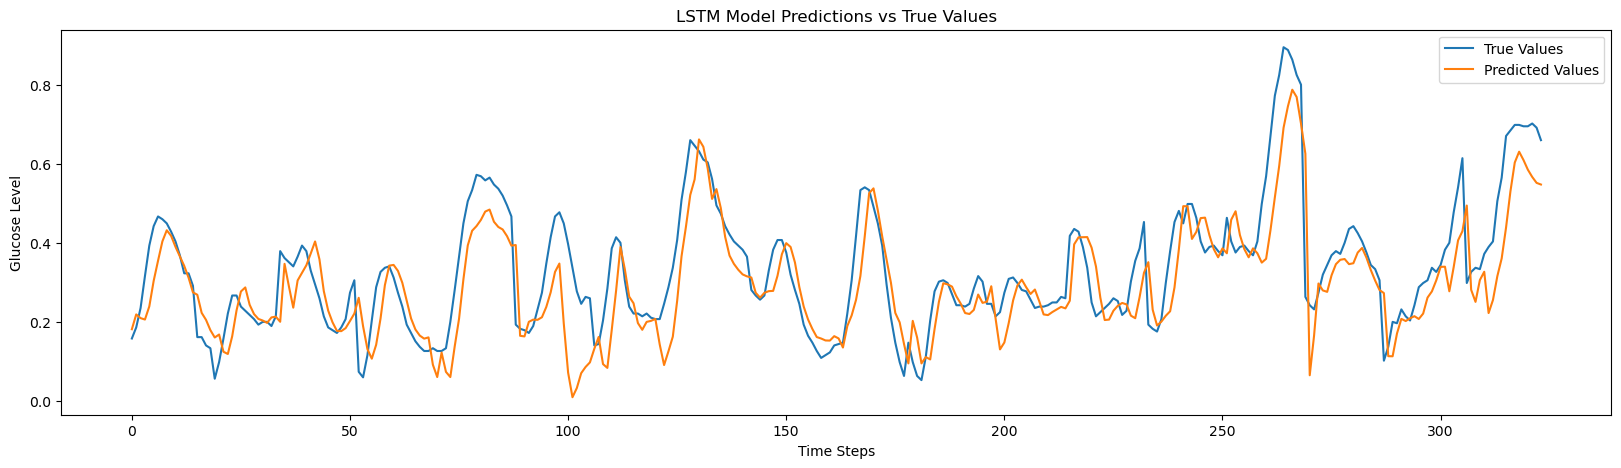

In [2]:


# Prepare the data for LSTM
X, y = prepare_data(train_data_combined_scaled)
X_test, y_test = prepare_data(test_data_combined_scaled)

# Split the training data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# LSTM Model Definition
def create_lstm_model(input_shape):
    model = Sequential()
    model.add(LSTM(50, activation='relu', input_shape=input_shape))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mse')
    return model

# Train the LSTM model
input_shape = (X_train.shape[1], X_train.shape[2])
lstm_model = create_lstm_model(input_shape)
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
lstm_model.fit(X_train, y_train, epochs=30, batch_size=32, validation_data=(X_val, y_val), callbacks=[early_stopping])


# Make predictions
y_train_pred = lstm_model.predict(X_train)
y_test_pred = lstm_model.predict(X_test)

# Inverse transform predictions and true values
y_train_pred_inv = scaler.inverse_transform(np.concatenate([y_train_pred, np.zeros((y_train_pred.shape[0], train_data_combined.shape[1] - 1))], axis=1))[:, 0]
y_test_pred_inv = scaler.inverse_transform(np.concatenate([y_test_pred, np.zeros((y_test_pred.shape[0], test_data_combined.shape[1] - 1))], axis=1))[:, 0]
y_train_inv = scaler.inverse_transform(np.concatenate([y_train.reshape(-1, 1), np.zeros((y_train.shape[0], train_data_combined.shape[1] - 1))], axis=1))[:, 0]
y_test_inv = scaler.inverse_transform(np.concatenate([y_test.reshape(-1, 1), np.zeros((y_test.shape[0], test_data_combined.shape[1] - 1))], axis=1))[:, 0]

# Plot results
plt.figure(figsize=(20, 5))
plt.plot(y_test_inv, label="True Values")
plt.plot(y_test_pred_inv, label="Predicted Values")
plt.xlabel("Time Steps")
plt.ylabel("Glucose Level")
plt.title("LSTM Model Predictions vs True Values")
plt.legend()
plt.show()